<a href="https://colab.research.google.com/github/crislenenunes/TalentScopeCS/blob/main/TalentScope_CS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Gerarando Banco de Dados

Ao executar esse código, é gerado um arquivo .csv para treinar o modelo.



In [114]:
import pandas as pd
import numpy as np
from google.colab import files

# Configuração
np.random.seed(42)
n_candidatos = 200

# Gerar nomes realistas
nomes = []
for i in range(1, n_candidatos+1):
    primeiro_nome = np.random.choice(['João', 'Maria', 'Carlos', 'Ana', 'Pedro', 'Juliana', 'Lucas', 'Fernanda'])
    sobrenome = np.random.choice(['Silva', 'Souza', 'Oliveira', 'Santos', 'Costa', 'Lima', 'Pereira', 'Rocha'])
    nomes.append(f"{primeiro_nome} {sobrenome}")

# Gerar dados
data = {
    'id': range(1, n_candidatos+1),
    'nome': nomes,
    'tempo_experiencia': np.random.randint(0, 25, n_candidatos),
    'conhecimento_crm': np.random.choice([1,2,3,4,5], n_candidatos, p=[0.1,0.2,0.3,0.25,0.15]),
    'ingles': np.random.choice([1,2,3,4,5], n_candidatos, p=[0.05,0.15,0.3,0.3,0.2]),
    'graduacao': np.random.choice(["Cursando", "Completo"], n_candidatos, p=[0.6,0.4]),
    'cursos_extras': np.random.choice([
        "", "CRM Básico", "Salesforce", "Zendesk", "HubSpot",
        "Salesforce,Zendesk", "CRM Avançado", "Atendimento ao Cliente"
    ], n_candidatos, p=[0.3,0.2,0.15,0.1,0.1,0.05,0.05,0.05]),
    'soft_skills': np.random.choice([
        "", "comunicação", "empatia", "organização",
        "proatividade", "trabalho em equipe", "resolução problemas",
        "comunicação,empatia", "organização,proatividade"
    ], n_candidatos),
    'aderente': 0
}

df = pd.DataFrame(data)

# Calcular aderência com regras mais realistas
df['aderente'] = (
    (df['tempo_experiencia'] >= np.random.randint(4, 8)) &  # Mínimo entre 4-7 meses
    (df['conhecimento_crm'] >= np.random.randint(2, 4)) &   # Mínimo entre 2-3
    (df['ingles'] >= np.random.randint(2, 4)) &             # Mínimo entre 2-3
    (np.random.random(n_candidatos) > 0.2)                  # 20% de ruído
).astype(int)

# Ajustar formatação
df['cursos_extras'] = df['cursos_extras'].replace('', 'Nenhum')
df['soft_skills'] = df['soft_skills'].replace('', 'Nenhuma')

# Salvar CSV
df.to_csv('candidatos_estagio_cs.csv', index=False, encoding='utf-8-sig')

# Download automático
files.download('candidatos_estagio_cs.csv')

print("✅ CSV gerado com sucesso!")
print(f"Total de candidatos: {len(df)}")
print(f"Candidatos aderentes: {df['aderente'].sum()} ({df['aderente'].mean():.1%})")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ CSV gerado com sucesso!
Total de candidatos: 200
Candidatos aderentes: 85 (42.5%)


##1. Instalando as bibliotecas

In [115]:
!pip install PyPDF2 gradio scikit-learn pandas numpy
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##2. Configuração Inicial

In [116]:
import pandas as pd
import numpy as np
import gradio as gr
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from joblib import dump, load
from PyPDF2 import PdfReader
import io
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

##3. Montando o Google Drive

In [117]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##4. Carregando os dados

In [118]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/candidatos_estagio_cs.csv')
print("CSV carregado do Google Drive")
print(df)

CSV carregado do Google Drive
      id            nome  tempo_experiencia  conhecimento_crm  ingles  \
0      1    Lucas Santos                 20                 4       2   
1      2   Pedro Pereira                 22                 4       5   
2      3    Carlos Rocha                  0                 1       2   
3      4     Pedro Costa                  2                 3       4   
4      5     Lucas Souza                 17                 1       3   
..   ...             ...                ...               ...     ...   
245  246  Fernanda Costa                 24                 2       3   
246  247       João Lima                 19                 2       3   
247  248   Pedro Pereira                 20                 2       5   
248  249   Carlos Santos                  3                 2       4   
249  250     João Santos                 20                 2       2   

    graduacao cursos_extras  aderente  
0    Completo    Salesforce         1  
1    Cursando

##5. Pré-processamento

In [119]:
##5. Pré-processamento

def preprocess_data(df):
    # Cria uma cópia explícita para evitar warnings
    df_clean = df.copy()

    # 1. Converter graduação para numérico (forma segura)
    df_clean['graduacao'] = df_clean['graduacao'].map({'Cursando': 1, 'Completo': 0})

    # 2. Verificar e tratar valores nulos (forma atualizada)
    null_counts = df_clean.isnull().sum()

    if null_counts.any():
        print("\n Valores nulos encontrados:")
        print(null_counts[null_counts > 0])

        for col in null_counts[null_counts > 0].index:
            if df_clean[col].dtype in ['int64', 'float64']:
                # Forma recomendada para preenchimento
                median_val = df_clean[col].median()
                print(f"Preenchendo {col} com mediana: {median_val}")
                df_clean[col] = df_clean[col].fillna(median_val)  # ← Método seguro
            else:
                # Forma recomendada para preenchimento
                mode_val = df_clean[col].mode()[0]
                print(f"Preenchendo {col} com moda: {mode_val}")
                df_clean[col] = df_clean[col].fillna(mode_val)  # ← Método seguro
    else:
        print("\n Nenhum valor nulo encontrado.")

    return df_clean

df_clean = preprocess_data(df)  # Atribuição correta


 Valores nulos encontrados:
cursos_extras    46
dtype: int64
Preenchendo cursos_extras com moda: Zendesk


##6. Divisão dos dados

In [120]:
X = df_clean[['tempo_experiencia', 'conhecimento_crm', 'ingles', 'graduacao']]
y = df_clean['aderente']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Manter proporção das classes
)

##7. Treinando o modelo

In [121]:
model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)
print("\n Modelo treinado com sucesso!")


 Modelo treinado com sucesso!


##8. Avaliacação do modelo

<Figure size 800x600 with 0 Axes>

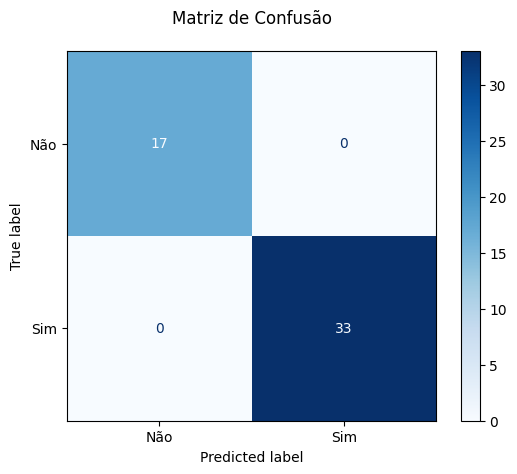


📊 Relatório de Classificação:
              precision    recall  f1-score   support

Não Aderente       1.00      1.00      1.00        17
    Aderente       1.00      1.00      1.00        33

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



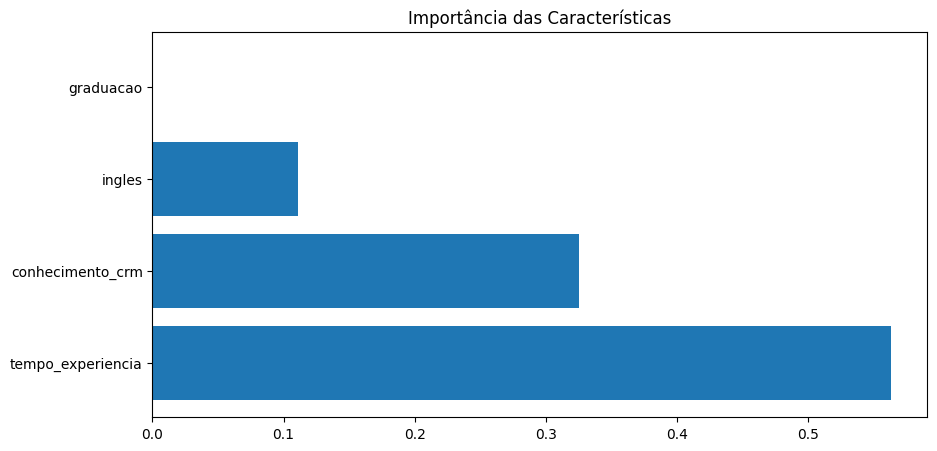

In [122]:
def evaluate_model(model, X_test, y_test):
    # Previsões
    y_pred = model.predict(X_test)

    # 1. Matriz de Confusão
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não', 'Sim'])
    disp.plot(cmap='Blues')
    plt.title('Matriz de Confusão', pad=20)
    plt.show()

    # 2. Relatório de Classificação
    print("\n📊 Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['Não Aderente', 'Aderente']))

    # 3. Importância das Features
    plt.figure(figsize=(10,5))
    plt.barh(X.columns, model.feature_importances_)
    plt.title('Importância das Características')
    plt.show()

evaluate_model(model, X_test, y_test)

##9. Salvando o modelo

In [123]:
dump(model, '/content/drive/MyDrive/Colab Notebooks/modelo_estagio_cs.joblib')
print("\n Modelo salvo no Google Drive")


 Modelo salvo no Google Drive


##10. Criando a interface Gradio

In [125]:
##10. Criando a interface Gradio

def predict_aderencia(tempo_exp, conhecimento_crm, ingles, graduacao, curriculo_input):
    # Processar currículo (PDF ou texto)
    resume_text = ""
    if curriculo_input is not None:
        if isinstance(curriculo_input, str):  # Texto direto
            resume_text = curriculo_input
        else:  # Arquivo PDF
            resume_text = extract_text_from_pdf(curriculo_input)

    # Analisar currículo
    resume_analysis = analyze_resume_content(resume_text)

    # Preparar inputs para o modelo
    input_data = np.array([[
        tempo_exp,
        conhecimento_crm,
        ingles,
        1 if graduacao == "Cursando" else 0
    ]])

    # Fazer previsão
    proba = model.predict_proba(input_data)[0][1] * 100
    proba_ajustada = min(100, proba + resume_analysis['pontuacao'] * 3)  # Bônus de até 30%

    # Gerar feedback
    return {
        "Probabilidade Base": f"{proba:.1f}%",
        "Bônus do Currículo": f"+{resume_analysis['pontuacao'] * 3:.1f}%",
        "Probabilidade Final": f"{proba_ajustada:.1f}%",
        "Status": "✅ Aderente" if proba_ajustada >= 70 else "❌ Não Aderente",
        "Palavras-chave Encontradas": resume_analysis['keywords'] or "Nenhuma relevante",
        "Dica Currículo": "✔️ Ótimo!" if resume_analysis['pontuacao'] >= 5 else "✖️ Adicione mais termos como 'CRM' ou 'Customer Success'"
    }

with gr.Blocks(title="Analisador CS com Currículo") as app:
    gr.Markdown("# 📄 Analisador para Estágio em Customer Success")

    with gr.Row():
        with gr.Column():
            # Inputs principais
            tempo_exp = gr.Slider(label="Tempo de Experiência (meses)", minimum=0, maximum=24)
            conhecimento_crm = gr.Slider(label="Conhecimento de CRM (1-5)", minimum=1, maximum=5)
            ingles = gr.Slider(label="Nível de Inglês (1-5)", minimum=1, maximum=5)
            graduacao = gr.Radio(label="Graduação", choices=["Cursando", "Completo"])

            # Upload de currículo
            gr.Markdown("## 📎 Anexar Currículo")
            with gr.Tab("Upload PDF"):
                pdf_input = gr.File(label="Envie seu PDF", file_types=[".pdf"])
            with gr.Tab("Texto Direto"):
                text_input = gr.Textbox(label="Cole seu currículo aqui", lines=5)

            analyze_btn = gr.Button("Analisar", variant="primary")

        with gr.Column():
            gr.Markdown("## 📊 Resultado Completo")
            output = gr.JSON(label="Análise")

    # Lógica de análise
    analyze_btn.click(
        fn=predict_aderencia,
        inputs=[tempo_exp, conhecimento_crm, ingles, graduacao, pdf_input],
        outputs=output
    )

    # Alternar entre PDF e texto
    text_input.change(
        fn=lambda text: None if text else gr.File(),
        inputs=text_input,
        outputs=pdf_input
    )


app.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://31f1dac5dbffd24006.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 11. Gerando o arquivo do modelo para o Hugging Face

In [126]:
##7. Treinando o modelo
model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

## Gerar arquivo .joblib
from joblib import dump
dump(model, 'modelo_estagio_cs.joblib')

## Download automático
from google.colab import files
files.download('modelo_estagio_cs.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>